# Anomaly Detection with Masked Autoencoders

## Library imports

In [39]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Prepare data

In [40]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None, phase='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.phase = phase
        self.images = []
        self.labels = []

        if self.phase == 'train':
            img_dir = os.path.join(root_dir, 'train', 'good')
            self.images = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]
            self.labels = [0] * len(self.images)  # All normal images
        else:
            test_dir = os.path.join(root_dir, 'test')
            for defect_type in os.listdir(test_dir):
                defect_dir = os.path.join(test_dir, defect_type)
                imgs = [os.path.join(defect_dir, img) for img in os.listdir(defect_dir)]
                label = 0 if defect_type == 'good' else 1  # 0: normal, 1: anomaly
                self.images.extend(imgs)
                self.labels.extend([label] * len(imgs))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

In [41]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset paths
category = 'carpet'  # Choose your category
data_dir = '../data/mvtec_ad/' + category  # Update this path

# Create datasets
train_dataset = MVTecDataset(root_dir=data_dir, transform=transform, phase='train')
test_dataset = MVTecDataset(root_dir=data_dir, transform=transform, phase='test')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [42]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

Train dataset size: 280
Test dataset size: 117


## Masked Autoencoder Model

In [43]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, mask_ratio=0.6):
        super(MaskedAutoencoder, self).__init__()
        self.mask_ratio = mask_ratio

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 64 -> 128
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Apply masking
        mask = torch.rand_like(x) > self.mask_ratio
        x_masked = x * mask.float()

        # Encode and decode
        encoded = self.encoder(x_masked)
        decoded = self.decoder(encoded)
        return decoded, x

## Training

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskedAutoencoder(mask_ratio=0.75).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [45]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs, targets = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}')

Epoch [1/100], Loss: 0.020347
Epoch [2/100], Loss: 0.010333
Epoch [3/100], Loss: 0.008853
Epoch [4/100], Loss: 0.008248
Epoch [5/100], Loss: 0.007483
Epoch [6/100], Loss: 0.007235
Epoch [7/100], Loss: 0.007105
Epoch [8/100], Loss: 0.007005
Epoch [9/100], Loss: 0.006946
Epoch [10/100], Loss: 0.006899
Epoch [11/100], Loss: 0.006887
Epoch [12/100], Loss: 0.006882
Epoch [13/100], Loss: 0.006856
Epoch [14/100], Loss: 0.006830
Epoch [15/100], Loss: 0.006786
Epoch [16/100], Loss: 0.006772
Epoch [17/100], Loss: 0.006747
Epoch [18/100], Loss: 0.006744
Epoch [19/100], Loss: 0.006732
Epoch [20/100], Loss: 0.006713
Epoch [21/100], Loss: 0.006709
Epoch [22/100], Loss: 0.006674
Epoch [23/100], Loss: 0.006658
Epoch [24/100], Loss: 0.006637
Epoch [25/100], Loss: 0.006617
Epoch [26/100], Loss: 0.006641
Epoch [27/100], Loss: 0.006619
Epoch [28/100], Loss: 0.006612
Epoch [29/100], Loss: 0.006603
Epoch [30/100], Loss: 0.006614
Epoch [31/100], Loss: 0.006609
Epoch [32/100], Loss: 0.006602
Epoch [33/100], L

KeyboardInterrupt: 

In [46]:
criterion = nn.MSELoss(reduction='none')

def evaluate(model, data_loader):
    model.eval()
    losses = []
    labels_list = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs, targets = model(images)
            loss = criterion(outputs, targets)  # Shape: [batch_size, channels, height, width]
            # Calculate mean loss per sample
            loss_per_sample = loss.mean(dim=[1, 2, 3])  # Shape: [batch_size]
            loss_per_sample_np = loss_per_sample.cpu().numpy()  # Convert to NumPy array

            # Debugging prints
            print(f"Batch {batch_idx}:")
            print(f"  loss_per_sample shape: {loss_per_sample_np.shape}")
            print(f"  loss_per_sample contents: {loss_per_sample_np}")

            # Extend the losses list
            losses.extend(loss_per_sample_np)  # Should be a list of scalars
            labels_list.extend(labels.cpu().numpy())

    return losses, labels_list

# Calculate reconstruction losses
test_losses, test_labels = evaluate(model, test_loader)

# Convert lists to numpy arrays
test_losses = np.array(test_losses)
test_labels = np.array(test_labels)

# Separate normal and anomalous losses
normal_losses = test_losses[test_labels == 0]
anomaly_losses = test_losses[test_labels == 1]

print(f'Average Normal Loss: {normal_losses.mean():.6f}')
print(f'Average Anomaly Loss: {anomaly_losses.mean():.6f}')

Batch 0:
  loss_per_sample shape: (16,)
  loss_per_sample contents: [0.00593035 0.00624057 0.00751642 0.00705793 0.00733422 0.00721877
 0.00657538 0.00621776 0.00725785 0.00717858 0.00725876 0.00632032
 0.00632753 0.00653071 0.00644377 0.00702438]
Batch 1:
  loss_per_sample shape: (16,)
  loss_per_sample contents: [0.00681619 0.00649107 0.00667716 0.00644114 0.0061734  0.00600018
 0.00589124 0.00619092 0.00606603 0.00628684 0.00598224 0.00622542
 0.00606964 0.00604517 0.0062838  0.00659311]
Batch 2:
  loss_per_sample shape: (16,)
  loss_per_sample contents: [0.00592291 0.00696506 0.00728797 0.00691883 0.00632432 0.00672282
 0.00644598 0.00650601 0.00606979 0.00658604 0.00615446 0.00596728
 0.00628833 0.00654635 0.00636643 0.00689646]
Batch 3:
  loss_per_sample shape: (16,)
  loss_per_sample contents: [0.00666556 0.00674288 0.00694974 0.00721303 0.007065   0.00735004
 0.00677024 0.0067218  0.00658121 0.0064621  0.00659636 0.00652587
 0.00624067 0.00649075 0.00654984 0.00655262]
Batch 4:

## Set AD Threshold

In [47]:
# Set threshold (e.g., mean + k * std of normal losses)
k = 1.5
threshold = normal_losses.mean() + k * normal_losses.std()

# Make predictions
predictions = (test_losses > threshold).astype(int)

# Calculate accuracy
accuracy = (predictions == test_labels).mean()
print(f'Anomaly Detection Accuracy: {accuracy:.4f}')

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
print('Confusion Matrix:')
print(cm)

Anomaly Detection Accuracy: 0.3419
Confusion Matrix:
[[25  3]
 [74 15]]


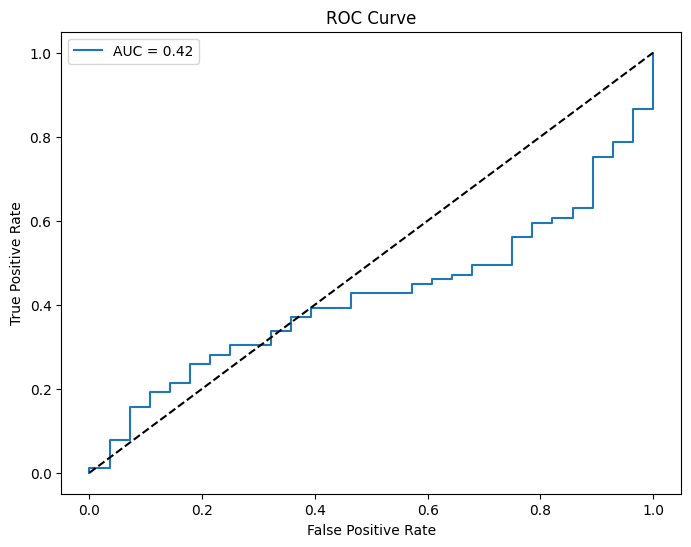

In [48]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, test_losses)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

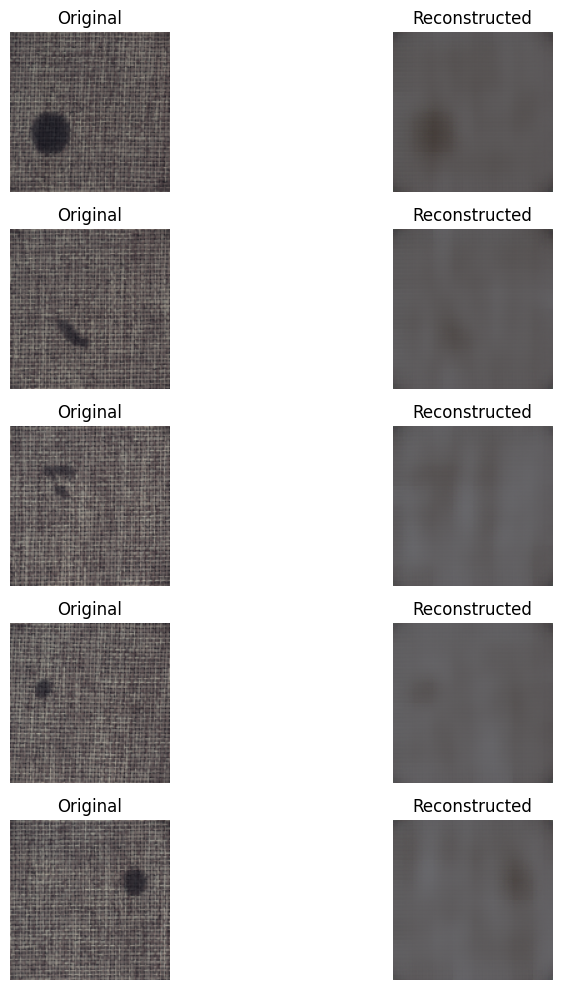

In [49]:
def visualize_reconstruction(model, data_loader, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images[:num_images].to(device)
    outputs, _ = model(images)

    images = images.cpu().numpy()
    outputs = outputs.cpu().detach().numpy()

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))
    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        # Reconstructed image
        axes[i, 1].imshow(np.transpose(outputs[i], (1, 2, 0)))
        axes[i, 1].set_title('Reconstructed')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize reconstructions
visualize_reconstruction(model, test_loader)